In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-4/Data-dictionary.xlsx
/kaggle/input/data-storm-4/DataStorm4.0_KaggleProblemStatement.pdf
/kaggle/input/data-storm-4/Store-info.csv
/kaggle/input/data-storm-4/Testing-data.csv
/kaggle/input/data-storm-4/Historical-transaction-data.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df_1 = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv')
df_2 = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')
df_3=pd.read_csv("/kaggle/input/data-storm-4/Testing-data.csv")




### Fill missing value

In [4]:
null_counts = df_1.isnull().sum()
print(null_counts)

item_description    35928
transaction_date        0
invoice_id           6320
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
dtype: int64


In [5]:
df_1 = df_1.drop_duplicates()


In [6]:
df_1['item_description'] = df_1['item_description'].fillna("NAN SODA 1L")

In [7]:
grouped = df_1.groupby(['shop_id'])

# loop through each group
for name, group in grouped:
    # find the maximum invoice_id value for the group
    max_invoice_id = group['invoice_id'].max()
    
    # fill missing invoice_id values with new ones based on the maximum value for the group
    group['invoice_id'].fillna(max_invoice_id + 1, inplace=True)
    
    # replace the group in the original dataframe with the updated group
    df_1.loc[group.index] = group


In [8]:
null_counts = df_1.isnull().sum()
print(null_counts)

item_description    0
transaction_date    0
invoice_id          0
customer_id         0
shop_id             0
item_price          0
quantity_sold       0
dtype: int64


### Split the date to features

In [9]:
dates = df_1['transaction_date']
Dates = []

# Extract the substring corresponding to the day component
for date in dates:
    day_string = date[8:10]
    
    # Convert the day string to an integer
    day = int(day_string)
    
    Dates.append(day)
    
    
df_1['date'] =  Dates

In [10]:
sl_holidays = [pd.to_datetime(d) for d in ['2021-10-19', '2021-10-20', '2021-11-04', '2022-11-18', 
                                           '2022-12-18', '2022-12-25']]

# assume that the transaction_date column is a string column
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

# now you can use the .dt accessor on the transaction_date column
df_1['is_weekend'] = df_1['transaction_date'].dt.weekday.isin([5, 6])

df_1['is_holiday'] = df_1['transaction_date'].isin(sl_holidays)

# convert boolean values to integers
df_1['is_weekend'] = df_1['is_weekend'].astype(int)

df_1['is_holiday'] = df_1['is_holiday'].astype(int)

In [11]:
df_1.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0
1,GINGER BEER 1.5L,2021-10-17 00:00:00+00:00,371.0,IA25,SHOP112,220,2,17,1,0
2,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0
3,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0
4,STRAWBERRY MILK 180ML,2021-10-23 00:00:00+00:00,1310.0,7S00,SHOP112,210,5,23,1,0


In [12]:
shop_invoice_count = df_1.groupby('shop_id')['invoice_id'].count()
# shop_invoice_counts = df_1.groupby('shop_id')['invoice_id'].value_counts().reset_index(name='invoice_count')
# shop_invoice_counts

In [13]:
shop_invoice_count= pd.DataFrame(shop_invoice_count)
shop_invoice_count = shop_invoice_count.rename(columns={'invoice_id': 'count_invoice'})
# shop_invoice_count 

### Spilit the Item_description 

In [14]:

# extract item_name and item_size from item_description
df_1[['item_name', 'item_size']] = df_1['item_description'].str.extract('([\w\s]+) (\d*\.?\d+)\w{0,2}$')

# convert item_size to liters
df_1['item_size'] = df_1['item_size'].astype(float)
df_1.loc[df_1['item_description'].str.contains('ML', na=False), 'item_size'] /= 1000

# display the result
# df_1.head

### Merge two data set

In [15]:
# df_2 = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')

# Merge the two DataFrames on the primary key column
df_11 = pd.merge(shop_invoice_count, df_2, on='shop_id')
# df_1=pd.merge(df_1,shop_invoice_count, on='shop_id')
df_12= pd.merge(df_1, df_11, on='shop_id')
# df_12
df_1=df_12
df_1

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday,item_name,item_size,count_invoice,shop_area_sq_ft,shop_profile
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0,ORANGE BARLEY,1.5,244,678,Moderate
1,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0,TONIC PET,0.5,244,678,Moderate
2,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0,CREAM SODA,1.0,244,678,Moderate
3,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate
4,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,440,1,10,0,0,GINGER BEER,1.5,244,678,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,NAN SODA 1L,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,70,1,9,0,0,NAN SODA,1.0,4160,617,High
442759,FIT O ORANGE 200ML,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,140,2,11,1,0,FIT O ORANGE,0.2,4160,617,High
442760,BOTTLED DRINKING WATER 500ML,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,35,1,11,1,0,BOTTLED DRINKING WATER,0.5,4160,617,High
442761,GINGER BEER 1.5L,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,220,1,21,0,0,GINGER BEER,1.5,4160,617,High


### Correct the item price

In [16]:
# # df_1['item_price'] = df_1.groupby(['item_description'])['item_price'].apply(lambda x: x.fill(x.mode()[0]))
# df_1['item_price'] = df_1.groupby('item_description')['item_price'].transform(lambda x: x.fill(x.mode()[0]))

# df_1

def get_mode(series):
    return series.mode().iloc[0]

# Group the data frame by the primary key column and apply the mode function to each group
mode_values = df_1.groupby('item_description')['item_price'].transform(get_mode)

# Identify values that are not equal to the mode value within each group
not_mode = df_1['item_price'] != mode_values

# Replace those values with the mode value using the loc method
df_1.loc[not_mode, 'item_price'] = mode_values
df_1

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday,item_name,item_size,count_invoice,shop_area_sq_ft,shop_profile
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0,ORANGE BARLEY,1.5,244,678,Moderate
1,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0,TONIC PET,0.5,244,678,Moderate
2,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0,CREAM SODA,1.0,244,678,Moderate
3,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate
4,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,NAN SODA 1L,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,70,1,9,0,0,NAN SODA,1.0,4160,617,High
442759,FIT O ORANGE 200ML,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,60,2,11,1,0,FIT O ORANGE,0.2,4160,617,High
442760,BOTTLED DRINKING WATER 500ML,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,35,1,11,1,0,BOTTLED DRINKING WATER,0.5,4160,617,High
442761,GINGER BEER 1.5L,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,220,1,21,0,0,GINGER BEER,1.5,4160,617,High


### Add new feature

In [17]:
df_1['total_amount'] = df_1['item_price']*df_1['quantity_sold']
df_1.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday,item_name,item_size,count_invoice,shop_area_sq_ft,shop_profile,total_amount
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0,ORANGE BARLEY,1.5,244,678,Moderate,440
1,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0,TONIC PET,0.5,244,678,Moderate,320
2,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0,CREAM SODA,1.0,244,678,Moderate,300
3,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate,220
4,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate,220


In [18]:
grouped = df_1.groupby('shop_id')

# Calculate the income and total quantity sold for each shop
income = grouped.apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())
quantity = grouped['quantity_sold'].sum()

# Combine the income and quantity data into a new DataFrame
grouped = pd.concat([income, quantity], axis=1)

# Rename the columns
grouped.columns = ['income', 'total_quantity']
grouped['income_per_quantity'] = grouped['income']/grouped['total_quantity']
grouped
df_13=pd.merge(df_1, grouped, on='shop_id')
df_1=df_13
df_1

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday,item_name,item_size,count_invoice,shop_area_sq_ft,shop_profile,total_amount,income,total_quantity,income_per_quantity
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0,ORANGE BARLEY,1.5,244,678,Moderate,440,71625,461,155.368764
1,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0,TONIC PET,0.5,244,678,Moderate,320,71625,461,155.368764
2,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0,CREAM SODA,1.0,244,678,Moderate,300,71625,461,155.368764
3,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate,220,71625,461,155.368764
4,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate,220,71625,461,155.368764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,NAN SODA 1L,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,70,1,9,0,0,NAN SODA,1.0,4160,617,High,70,1184460,8173,144.923529
442759,FIT O ORANGE 200ML,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,60,2,11,1,0,FIT O ORANGE,0.2,4160,617,High,120,1184460,8173,144.923529
442760,BOTTLED DRINKING WATER 500ML,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,35,1,11,1,0,BOTTLED DRINKING WATER,0.5,4160,617,High,35,1184460,8173,144.923529
442761,GINGER BEER 1.5L,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,220,1,21,0,0,GINGER BEER,1.5,4160,617,High,220,1184460,8173,144.923529


In [19]:
# convert transaction_date column to datetime type
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

# calculate week of the month
df_1['weekper_month'] = ((df_1['transaction_date'].dt.day - 1) // 7 + 1)

# print dataframe
df_1

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday,item_name,item_size,count_invoice,shop_area_sq_ft,shop_profile,total_amount,income,total_quantity,income_per_quantity,weekper_month
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0,ORANGE BARLEY,1.5,244,678,Moderate,440,71625,461,155.368764,2
1,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0,TONIC PET,0.5,244,678,Moderate,320,71625,461,155.368764,2
2,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0,CREAM SODA,1.0,244,678,Moderate,300,71625,461,155.368764,2
3,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate,220,71625,461,155.368764,2
4,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,220,1,10,0,0,GINGER BEER,1.5,244,678,Moderate,220,71625,461,155.368764,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,NAN SODA 1L,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,70,1,9,0,0,NAN SODA,1.0,4160,617,High,70,1184460,8173,144.923529,2
442759,FIT O ORANGE 200ML,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,60,2,11,1,0,FIT O ORANGE,0.2,4160,617,High,120,1184460,8173,144.923529,2
442760,BOTTLED DRINKING WATER 500ML,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,35,1,11,1,0,BOTTLED DRINKING WATER,0.5,4160,617,High,35,1184460,8173,144.923529,2
442761,GINGER BEER 1.5L,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,220,1,21,0,0,GINGER BEER,1.5,4160,617,High,220,1184460,8173,144.923529,3


In [20]:

# Convert transaction_date column to datetime object
df_1['transaction_date'] = pd.to_datetime(df_1['transaction_date'])

# Group by week and calculate weekly income
df_1['weekly_income'] = df_1.groupby(df_1['transaction_date'].dt.week)['total_amount'].transform('sum')
df_1

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday,...,item_size,count_invoice,shop_area_sq_ft,shop_profile,total_amount,income,total_quantity,income_per_quantity,weekper_month,weekly_income
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0,...,1.5,244,678,Moderate,440,71625,461,155.368764,2,20522500
1,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0,...,0.5,244,678,Moderate,320,71625,461,155.368764,2,7263910
2,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0,...,1.0,244,678,Moderate,300,71625,461,155.368764,2,7263910
3,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,220,1,10,0,0,...,1.5,244,678,Moderate,220,71625,461,155.368764,2,20522500
4,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,220,1,10,0,0,...,1.5,244,678,Moderate,220,71625,461,155.368764,2,20522500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,NAN SODA 1L,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,70,1,9,0,0,...,1.0,4160,617,High,70,1184460,8173,144.923529,2,20522500
442759,FIT O ORANGE 200ML,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,60,2,11,1,0,...,0.2,4160,617,High,120,1184460,8173,144.923529,2,20522500
442760,BOTTLED DRINKING WATER 500ML,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,35,1,11,1,0,...,0.5,4160,617,High,35,1184460,8173,144.923529,2,20522500
442761,GINGER BEER 1.5L,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,220,1,21,0,0,...,1.5,4160,617,High,220,1184460,8173,144.923529,3,17126220


### Filling the missing value

In [21]:
# df_1['item_name'] = df_1['item_name'].fillna("SODA")
mean_int = int(df_1['item_size'].mean())
df_1['item_size'] =df_1['item_size'].fillna(mean_int)

df_1

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date,is_weekend,is_holiday,...,item_size,count_invoice,shop_area_sq_ft,shop_profile,total_amount,income,total_quantity,income_per_quantity,weekper_month,weekly_income
0,ORANGE BARLEY 1.5L,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,220,2,11,1,0,...,1.5,244,678,Moderate,440,71625,461,155.368764,2,20522500
1,TONIC PET 500ML,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,160,2,13,0,0,...,0.5,244,678,Moderate,320,71625,461,155.368764,2,7263910
2,CREAM SODA 1L,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,150,2,13,0,0,...,1.0,244,678,Moderate,300,71625,461,155.368764,2,7263910
3,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,220,1,10,0,0,...,1.5,244,678,Moderate,220,71625,461,155.368764,2,20522500
4,GINGER BEER 1.5L,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,220,1,10,0,0,...,1.5,244,678,Moderate,220,71625,461,155.368764,2,20522500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,NAN SODA 1L,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,70,1,9,0,0,...,1.0,4160,617,High,70,1184460,8173,144.923529,2,20522500
442759,FIT O ORANGE 200ML,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,60,2,11,1,0,...,0.2,4160,617,High,120,1184460,8173,144.923529,2,20522500
442760,BOTTLED DRINKING WATER 500ML,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,35,1,11,1,0,...,0.5,4160,617,High,35,1184460,8173,144.923529,2,20522500
442761,GINGER BEER 1.5L,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,220,1,21,0,0,...,1.5,4160,617,High,220,1184460,8173,144.923529,3,17126220


### Change the data frame Order

In [22]:
new_order = ['transaction_date','invoice_id','customer_id','shop_id','item_name','item_size','item_price','quantity_sold','total_amount','income_per_quantity', 'shop_area_sq_ft','date','is_weekend','is_holiday','count_invoice', 'shop_profile','weekly_income','weekper_month','income'
            ]

# Reorder the columns in the dataframe
df_1 = df_1[new_order]
# df_1.head()
df_1

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,shop_area_sq_ft,date,is_weekend,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income
0,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,ORANGE BARLEY,1.5,220,2,440,155.368764,678,11,1,0,244,Moderate,20522500,2,71625
1,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,TONIC PET,0.5,160,2,320,155.368764,678,13,0,0,244,Moderate,7263910,2,71625
2,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,CREAM SODA,1.0,150,2,300,155.368764,678,13,0,0,244,Moderate,7263910,2,71625
3,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,GINGER BEER,1.5,220,1,220,155.368764,678,10,0,0,244,Moderate,20522500,2,71625
4,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,GINGER BEER,1.5,220,1,220,155.368764,678,10,0,0,244,Moderate,20522500,2,71625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,NAN SODA,1.0,70,1,70,144.923529,617,9,0,0,4160,High,20522500,2,1184460
442759,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,FIT O ORANGE,0.2,60,2,120,144.923529,617,11,1,0,4160,High,20522500,2,1184460
442760,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,BOTTLED DRINKING WATER,0.5,35,1,35,144.923529,617,11,1,0,4160,High,20522500,2,1184460
442761,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,GINGER BEER,1.5,220,1,220,144.923529,617,21,0,0,4160,High,17126220,3,1184460


### Outliers

In [23]:
for i in df_1:
    if i not in ['transaction_date','invoice_id','customer_id','shop_id','item_name','shop_profile','item_encoded','is_weekend','is_holiday']:
        # calculate the interquartile range (IQR)
        Q1 = df_1[i].quantile(0.25)
        Q3 = df_1[i].quantile(0.75)
        IQR = Q3 - Q1

        # count the outliers
        outliers = ((df_1[i] < (Q1 - 1.5 * IQR)) | (df_1[i] > (Q3 + 1.5 * IQR))).sum()

        print(i,outliers)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
#         non_outliers_mean = np.mean(df_1[(df_1[i] >= lower_bound) & (df_1[i] <= upper_bound)][i])
        non_outliers_max = np.max(df_1[(df_1[i] >= lower_bound) & (df_1[i] <= upper_bound)][i])
        non_outliers_min = np.min(df_1[(df_1[i] >= lower_bound) & (df_1[i] <= upper_bound)][i])
        
        df_1.loc[(df_1[i] < lower_bound), i] = non_outliers_min
        df_1.loc[(df_1[i] > upper_bound), i] = non_outliers_max


item_size 0
item_price 39
quantity_sold 28568
total_amount 4533
income_per_quantity 7747
shop_area_sq_ft 53775
date 0
count_invoice 244
weekly_income 0
weekper_month 0
income 244


In [24]:
for i in df_1:
    if i not in ['transaction_date','invoice_id','customer_id','shop_id','item_name','shop_profile','item_encoded','is_weekend','is_holiday']:
        # calculate the interquartile range (IQR)
        Q1 = df_1[i].quantile(0.25)
        Q3 = df_1[i].quantile(0.75)
        IQR = Q3 - Q1

        # count the outliers
        outliers = ((df_1[i] < (Q1 - 1.5 * IQR)) | (df_1[i] > (Q3 + 1.5 * IQR))).sum()

        print(i,outliers)

item_size 0
item_price 0
quantity_sold 0
total_amount 0
income_per_quantity 0
shop_area_sq_ft 0
date 0
count_invoice 0
weekly_income 0
weekper_month 0
income 0


## Feature Scaling
### Min max Scaling


In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Sample dataset
for i in df_1:
    if i not in ['transaction_date','invoice_id','customer_id','shop_id','item_name','shop_profile','item_encoded','is_weekend','is_holiday','date']:
        col_data = df_1[i]

    # Perform min-max scaling on the selected column
        scaled_data = (col_data - col_data.min()) / (col_data.max() - col_data.min())

        # Update the selected column in the original data frame with the scaled data
        df_1[i] = scaled_data
df_1

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,shop_area_sq_ft,date,is_weekend,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income
0,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,ORANGE BARLEY,1.000000,0.725490,0.666667,0.623932,0.617086,0.642276,11,1,0,0.000000,Moderate,1.000000,0.25,0.000000
1,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,TONIC PET,0.242424,0.490196,0.666667,0.521368,0.617086,0.642276,13,0,0,0.000000,Moderate,0.000000,0.25,0.000000
2,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,CREAM SODA,0.621212,0.450980,0.666667,0.504274,0.617086,0.642276,13,0,0,0.000000,Moderate,0.000000,0.25,0.000000
3,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.617086,0.642276,10,0,0,0.000000,Moderate,1.000000,0.25,0.000000
4,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.617086,0.642276,10,0,0,0.000000,Moderate,1.000000,0.25,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442758,2021-12-09 00:00:00+00:00,7030409.0,QVA7,SHOP072,NAN SODA,0.621212,0.137255,0.333333,0.307692,0.358976,0.476965,9,0,0,0.565066,High,1.000000,0.25,0.579517
442759,2021-12-11 00:00:00+00:00,7030809.0,HXMG,SHOP072,FIT O ORANGE,0.015152,0.098039,0.666667,0.350427,0.358976,0.476965,11,1,0,0.565066,High,1.000000,0.25,0.579517
442760,2021-12-11 00:00:00+00:00,7030820.0,OUH2,SHOP072,BOTTLED DRINKING WATER,0.242424,0.000000,0.333333,0.277778,0.358976,0.476965,11,1,0,0.565066,High,1.000000,0.25,0.579517
442761,2021-10-21 00:00:00+00:00,7031845.0,5IJM,SHOP072,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.358976,0.476965,21,0,0,0.565066,High,0.743843,0.50,0.579517


In [26]:
maxrange = int(np.ceil(max(df_1['date'])))
minrange = int(np.floor(min(df_1['date'])))
daterange = maxrange - minrange
bins = 3
binwidth = int(np.round(daterange/bins))

In [27]:
print("maxrange is", maxrange)
print("minrange is", minrange)
print("daterange is", daterange)
print("bin width is", binwidth)

maxrange is 31
minrange is 1
daterange is 30
bin width is 10


In [28]:
intervals = [date for date in range(minrange, maxrange+binwidth, binwidth)]
intervals

[1, 11, 21, 31]

In [29]:
intervals = [0.969, 11.0, 21.0, 31.0]
labels = [0, 1, 2]

In [30]:
df_1['date_categorial'] = pd.cut(df_1['date'], bins=intervals, labels=labels, include_lowest=True)

Text(0, 0.5, 'observation count')

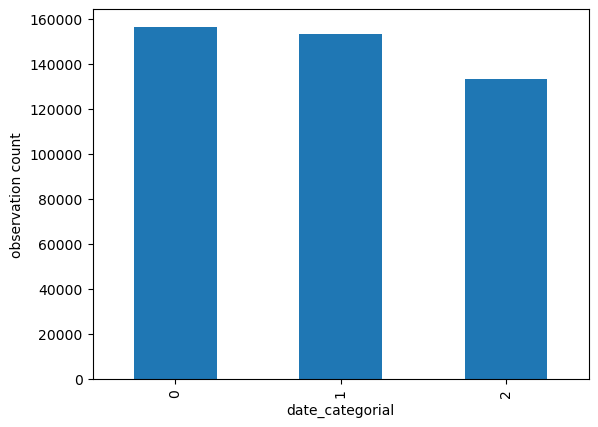

In [31]:
df_1.groupby('date_categorial')['date'].count().plot.bar()
plt.ylabel('observation count')

In [32]:
df_1.head()

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,shop_area_sq_ft,date,is_weekend,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income,date_categorial
0,2021-12-11 00:00:00+00:00,147.0,BGXA,SHOP008,ORANGE BARLEY,1.000000,0.725490,0.666667,0.623932,0.617086,0.642276,11,1,0,0.0,Moderate,1.0,0.25,0.0,0
1,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,TONIC PET,0.242424,0.490196,0.666667,0.521368,0.617086,0.642276,13,0,0,0.0,Moderate,0.0,0.25,0.0,1
2,2021-12-13 00:00:00+00:00,484.0,VN7V,SHOP008,CREAM SODA,0.621212,0.450980,0.666667,0.504274,0.617086,0.642276,13,0,0,0.0,Moderate,0.0,0.25,0.0,1
3,2021-12-10 00:00:00+00:00,1000053.0,VT9C,SHOP008,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.617086,0.642276,10,0,0,0.0,Moderate,1.0,0.25,0.0,0
4,2021-12-10 00:00:00+00:00,1000057.0,8QLS,SHOP008,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.617086,0.642276,10,0,0,0.0,Moderate,1.0,0.25,0.0,0


In [33]:
# unique_categories = df_1['item_name'].unique()
# num_categories = df_1['item_name'].nunique()
# print(unique_categories)
# print(num_categories)

In [34]:
# null_counts = df_1.isnull().sum()
# print(null_counts)

### Sorting

In [35]:
df_sorted = df_1.sort_values(by='shop_id')
df_1=df_sorted
df_1.head()

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,shop_area_sq_ft,date,is_weekend,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income,date_categorial
50020,2021-10-16 00:00:00+00:00,71340.0,9HZ9,SHOP001,ORANGE BARLEY,1.000000,0.725490,0.333333,0.435897,0.571246,0.376694,16,1,0,0.075168,Low,0.045764,0.50,0.107978,1
50814,2021-12-11 00:00:00+00:00,3035533.0,G0AJ,SHOP001,GINGER BEER,0.621212,0.450980,0.666667,0.504274,0.571246,0.376694,11,1,0,0.075168,Low,1.000000,0.25,0.107978,0
50815,2021-12-11 00:00:00+00:00,3035533.0,G0AJ,SHOP001,GINGER BEER,0.621212,0.450980,0.333333,0.376068,0.571246,0.376694,11,1,0,0.075168,Low,1.000000,0.25,0.107978,0
50816,2021-10-18 00:00:00+00:00,3035932.0,IQM6,SHOP001,GINGER BEER SUGAR FREE,0.242424,0.176471,0.333333,0.316239,0.571246,0.376694,18,0,0,0.075168,Low,0.743843,0.50,0.107978,1
50817,2021-12-09 00:00:00+00:00,3035932.0,YI1R,SHOP001,GINGER BEER,1.000000,0.725490,0.666667,0.623932,0.571246,0.376694,9,0,0,0.075168,Low,1.000000,0.25,0.107978,0


In [36]:
# df_sorted = df_sorted.dropna(subset=['item_name'])

In [37]:
# my_list = ['ORANGE BARLEY', 'TONIC PET', 'CREAM SODA', 'GINGER BEER','CREAM SODA APPLE POP', 'SODA', 'BOTTLED DRINKING WATER', 'LEMONADE','KIK COLA', 'STRAWBERRY MILK', 'SODA PET', 'FIT O MIXED FRUIT','NECTO', 'FIT O ORANGE', 'FIT O MANGO', 'GINGER BEER SUGAR FREE','ORANGE CRUSH', 'CHOCOLATE MILK', 'TWISTEE APPLE', 'DRY GINGER ALE PET', 'LIME CRUSH JUICE']
# len(my_list)
# my_dict = {i: my_list[i] for i in range(len(my_list))}

# # print(my_dict)
# swapped_dict = {v: k for k, v in my_dict.items()}

# print(swapped_dict)



### Instead (Label)

In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# create a sample DataFrame

# create a LabelEncoder object
le = LabelEncoder()

# fit and transform the 'fruits' column
df_1['item_encoded'] = le.fit_transform(df_1['item_name'])
df_1['customer_id_encoded']=le.fit_transform(df_1['customer_id'])
# df_1['shop_encoded'] = le.fit_transform(df_1['shop_id'])
encoded_df=df_1

In [39]:
# df_1.head()

### Plot

In [40]:
# grouped_df=df_1.copy()
# grouped_df['total']  = grouped_df.groupby(['item_name'])['quantity_sold'].transform('sum')
# grouped_df.head()

In [41]:
# grouped_df[["item_name","total"]]

In [42]:
# # Load the dataset into a pandas DataFrame

# # Create a line plot using seaborn
# plt.figure(figsize=(14,6))
# sns.lineplot(x='item_name', y='total', data=grouped_df)
# plt.xticks(rotation=90)

# # Add axis labels and a title to th

# # Show the plot
# plt.show()

In [43]:
encoded_df.head()

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,...,is_weekend,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income,date_categorial,item_encoded,customer_id_encoded
50020,2021-10-16 00:00:00+00:00,71340.0,9HZ9,SHOP001,ORANGE BARLEY,1.000000,0.725490,0.333333,0.435897,0.571246,...,1,0,0.075168,Low,0.045764,0.50,0.107978,1,15,50606
50814,2021-12-11 00:00:00+00:00,3035533.0,G0AJ,SHOP001,GINGER BEER,0.621212,0.450980,0.666667,0.504274,0.571246,...,1,0,0.075168,Low,1.000000,0.25,0.107978,0,8,85139
50815,2021-12-11 00:00:00+00:00,3035533.0,G0AJ,SHOP001,GINGER BEER,0.621212,0.450980,0.333333,0.376068,0.571246,...,1,0,0.075168,Low,1.000000,0.25,0.107978,0,8,85139
50816,2021-10-18 00:00:00+00:00,3035932.0,IQM6,SHOP001,GINGER BEER SUGAR FREE,0.242424,0.176471,0.333333,0.316239,0.571246,...,0,0,0.075168,Low,0.743843,0.50,0.107978,1,9,99809
50817,2021-12-09 00:00:00+00:00,3035932.0,YI1R,SHOP001,GINGER BEER,1.000000,0.725490,0.666667,0.623932,0.571246,...,0,0,0.075168,Low,1.000000,0.25,0.107978,0,8,183538


In [44]:
filtered_df = encoded_df[encoded_df['shop_profile'].notnull()]
na_df=encoded_df[encoded_df['shop_profile'].isnull()]
# encoded_df.head()
# filtered_df["shop_profile"]
# na_df.head()

In [45]:
na_df.drop('date', axis =1 , inplace = True)



### Label Encoding to Shop profile

In [46]:
# import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the CSV file into a pandas DataFrame
# df = pd.read_csv('filename.csv')

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder on the column and transform the column
#filtered_df['column_name_encoded'] = le.fit_transform(filtered_df["shop_profile"])

# Save the updated DataFrame to a new CSV file
# filtered_df.to_csv('filename_encoded.csv', index=False)

# define the mapping between original and encoded values
mapping = {'Moderate': 1, 'Low': 0, 'High': 2}

# fit the encoder to the 'shopprofile' column using the mapping
le.fit([mapping[val] for val in filtered_df['shop_profile']])

# transform the 'shopprofile' column using the fitted encoder
filtered_df['shop_profile_encoded'] = le.transform([mapping[val] for val in filtered_df['shop_profile']])


filtered_df.shape

(361487, 23)

In [47]:
filtered_df.drop('date', axis =1 , inplace = True)

In [48]:
# df_sorted = filtered_df.sort_values(by='shop_id')
# df_sorted

In [49]:
# plt.scatter(x=filtered_df['shop_area_sq_ft'], y=filtered_df['shop_profile_encoded'])

### Split the data frame

In [50]:
# calculate the index for splitting the dataframe
split_idx = int(0.8 * len(filtered_df))
# split the dataframe into training and testing sets
train_df =filtered_df.iloc[:split_idx]
test_df = filtered_df.iloc[split_idx:]
train_df.head()

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,...,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income,date_categorial,item_encoded,customer_id_encoded,shop_profile_encoded
50020,2021-10-16 00:00:00+00:00,71340.0,9HZ9,SHOP001,ORANGE BARLEY,1.000000,0.725490,0.333333,0.435897,0.571246,...,0,0.075168,Low,0.045764,0.50,0.107978,1,15,50606,0
50814,2021-12-11 00:00:00+00:00,3035533.0,G0AJ,SHOP001,GINGER BEER,0.621212,0.450980,0.666667,0.504274,0.571246,...,0,0.075168,Low,1.000000,0.25,0.107978,0,8,85139,0
50815,2021-12-11 00:00:00+00:00,3035533.0,G0AJ,SHOP001,GINGER BEER,0.621212,0.450980,0.333333,0.376068,0.571246,...,0,0.075168,Low,1.000000,0.25,0.107978,0,8,85139,0
50816,2021-10-18 00:00:00+00:00,3035932.0,IQM6,SHOP001,GINGER BEER SUGAR FREE,0.242424,0.176471,0.333333,0.316239,0.571246,...,0,0.075168,Low,0.743843,0.50,0.107978,1,9,99809,0
50817,2021-12-09 00:00:00+00:00,3035932.0,YI1R,SHOP001,GINGER BEER,1.000000,0.725490,0.666667,0.623932,0.571246,...,0,0.075168,Low,1.000000,0.25,0.107978,0,8,183538,0


In [51]:
# import pandas as pd

# # create two new data frames based on the primary key values
# # df1 = filtered_df[filtered_df['shop_id'] in ["SHOP" + str("{:03d}".format(i)) for i in range(101)]]
# train_df = filtered_df[filtered_df['shop_id'].str.startswith("SHOP") & filtered_df['shop_id'].str[4:].astype(int).between(0, 90)]
# test_df = filtered_df[filtered_df['shop_id'].str.startswith("SHOP") & filtered_df['shop_id'].str[4:].astype(int).between(91, 127)]

# # df2 = filtered_df[filtered_df['shop_id'] in ["SHOP" + str("{:03d}".format(i)) for i in range(101,128)]]

# # print the two new data frames
# # df2.tail()
# # x = ["SHOP" + str("{:03d}".format(i)) for i in range(128)]
# train_df.shape

In [52]:
test_df.shape

(72298, 22)

In [53]:
X_train=train_df.drop(columns=['transaction_date','invoice_id','customer_id','shop_id','shop_profile','shop_profile_encoded','item_name'])
y_train=train_df["shop_profile_encoded"]
X_test=test_df.drop(columns=['transaction_date','invoice_id','customer_id','shop_id','shop_profile','shop_profile_encoded','item_name'])
y_test=test_df["shop_profile_encoded"]

In [54]:
# X_train.isnull().sum()

In [55]:
# X=filtered_df.drop(columns=['is_holiday','transaction_date','invoice_id','customer_id','shop_id','shop_profile','shop_profile_encoded','item_name'])
# y=filtered_df["shop_profile_encoded"]

### Outliers

In [56]:
# def count_outliers(col_data):
#     Q1 = col_data.quantile(0.25)
#     Q3 = col_data.quantile(0.75)

#     # Calculate the interquartile range (IQR)
#     IQR = Q3 - Q1

#     # Define the threshold for outliers (1.5 times the IQR)
#     threshold = 1.5 * IQR

#     # Identify the outliers
#     outliers = col_data[(col_data < Q1 - threshold) | (col_data > Q3 + threshold)]

#     # Count the number of outliers
#     num_outliers = len(outliers)

#     print("Number of outliers in column", ":", num_outliers)



In [57]:
# X = X.fillna(0)
# X.head()

In [58]:
# from sklearn.model_selection import train_test_split

# y = filtered_df['shop_profile_encoded']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)

In [59]:
# X_train.head(5)

### Logistic

In [60]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# load the data into a DataFrame
# data = pd.read_csv('data.csv')

# # split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(data[['feature1', 'feature2', 'feature3']], data['target'], test_size=0.2)

# create a logistic regression object and fit the training data
lr = LogisticRegression()
lr.fit(X_train, y_train)

# evaluate the performance of the model on the test set
score = lr.score(X_test, y_test)
print(score * 100)

31.140557138510054


### SVM

In [61]:
# from sklearn import datasets
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC


# # Load the iris datase

# # Define the SVM classifier
# svm = SVC(kernel='linear')

# # Fit the training data
# svm.fit(X_train, y_train)

# # Predict the classes of new data
# # y_pred = clf.predict(X_test)

# # Print the accuracy score
# # print("Accuracy:", clf.score(X_test, y_test))


In [62]:
# import pandas as pd
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # load the data into a DataFrame
# # data = pd.read_csv('data.csv')

# # # split the data into training and test sets
# # X_train, X_test, y_train, y_test = train_test_split(data[['feature1', 'feature2', 'feature3']], data['target'], test_size=0.2)

# # create an SVM object and fit the training data
# svm = SVC(kernel='linear')
# svm.fit(X_train, y_train)

# # predict the class labels for the test set
# y_pred = svm.predict(X_test)

# # evaluate the performance of the model on the test set
# score = accuracy_score(y_test, y_pred)
# print("Accuracy: {:.2f}%".format(score * 100))


In [63]:
# import xgboost as xgb
# import numpy as np

# # Convert data to DMatrix format
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# # Set hyperparameters
# params = {
#     'objective': 'multi:softmax',
#     'num_class': len(np.unique(y_train)),
#     'max_depth': 6,
#     'eta': 0.3,
#     'eval_metric': 'merror'
# }

# # Train the model
# model = xgb.train(params, dtrain, num_boost_round=10)

# # Predict on test set
# y_pred = model.predict(dtest)

# # Evaluate the model
# accuracy = np.sum(y_pred == y_test) / len(y_test)
# print('Accuracy:', accuracy)

### Neural Network

In [64]:
# from sklearn.neural_network import MLPClassifier

# # create neural network classifier object
# clf = MLPClassifier(hidden_layer_sizes=(10,5), activation='relu', solver='adam', max_iter=200)

# # fit the classifier to the training data
# clf.fit(X_train, y_train)

# # predict the class labels for the test data
# y_pred = clf.predict(X_test)

# # calculate the accuracy of the classifier on the test data
# accuracy = clf.score(X_test, y_test)*100
# print('Accuracy of the  MLPClassifier is equal ' + str(round(accuracy, 2)) + ' %.')

### Random forest Bestuuuuuuu


In [65]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=90, random_state=30)

# Train the random forest classifier on the training data
rf.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = rf.score(X_test, y_test)*100
print('Accuracy of the  RandomForestClassifier is equal ' + str(round(accuracy, 2)) + ' %.')

# Get the feature importances from the classifier
importances = rf.feature_importances_

# Sort the features by importance
sorted_features = sorted(zip(importances, X_train.columns), reverse=True)

# Print the feature importances
for importance, feature in sorted_features:
    print('{}: {}'.format(feature, importance))

Accuracy of the  RandomForestClassifier is equal 65.2 %.
count_invoice: 0.26401752555296426
income_per_quantity: 0.26135077451455935
income: 0.25213616626448615
shop_area_sq_ft: 0.21299082253292154
customer_id_encoded: 0.0026435971978121505
item_encoded: 0.001509612318718335
item_price: 0.0012471783543082707
total_amount: 0.0010044538507268316
item_size: 0.0008754657722161655
weekly_income: 0.0008342934290038006
weekper_month: 0.0004982588600694461
quantity_sold: 0.00035345061192260764
is_weekend: 0.00027334925847694795
date_categorial: 0.0002650514818142191
is_holiday: 0.0


In [66]:
# from sklearn.ensemble import RandomForestClassifier
# for i in range(10,100,10):
#     for j in range(50,200,20):
#         # Create a random forest classifier with 100 trees
#         rf = RandomForestClassifier(n_estimators=j, random_state=i)

#         # Train the random forest classifier on the training data
#         rf.fit(X_train, y_train)

#         # Predict the classes of the testing data
#         y_pred = rf.predict(X_test)

#         # Evaluate the accuracy of the model
#         accuracy = rf.score(X_test, y_test)*100
#         print('Accuracy of the  RandomForestClassifier is equal '+str(i)+' '+str(j)+' ' + str(round(accuracy, 2)) + ' %.')


### Grid Decision Tree

In [67]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import make_classification
# import numpy as np

# # Generate some random data
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=0, random_state=42)

# # Define the decision tree classifier
# dtc = DecisionTreeClassifier(random_state=42)

# # Define the hyperparameters and their ranges for the grid search
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': np.arange(1, 11),
#     'min_samples_split': np.arange(2, 21),
#     'min_samples_leaf': np.arange(1, 11)
# }

# # Perform grid search cross-validation to find the best hyperparameters
# grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X, y)

# # Print the best hyperparameters
# print("Best hyperparameters:", grid_search.best_params_)


### Using DecisionTreeClassifier

In [68]:
# +



### Grid in Bagging

In [69]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split

# # Load the iris dataset

# # Define the BaggingClassifier model
# model = BaggingClassifier()

# # Define the hyperparameter grid to search over
# param_grid = {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 1.0], 'max_features': [0.5, 1.0]}

# # Define the GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# # Fit the GridSearchCV object to the training data
# grid.fit(X_train, y_train)

# # Print the best hyperparameters and accuracy score
# print("Best parameters: ", grid.best_params_)
# print("Best accuracy score: ", grid.best_score_)


### Bagging


In [70]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split



# # Create a bagging classifier with decision tree base estimator
# bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)

# # Fit the model to the training data
# bagging.fit(X_train, y_train)

# # Make predictions on the testing data
# y_pred = bagging.predict(X_test)

# # Calculate accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy:", accuracy)


### Naive_bayes algorithm

In [71]:
# # Import required libraries
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer


# # Split data into training and testing sets

# # Train the model
# clf = MultinomialNB()
# clf.fit(X_train, y_train)

# # Predict using the trained model
# y_pred = clf.predict(X_test)

# # Evaluate the model accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

### Using KNN algorithm

In [72]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import pandas as pd


# knn = KNeighborsClassifier(n_neighbors=5)

# # Fit the classifier to the training data
# knn.fit(X_train, y_train)

# # Predict the classes of the test data
# y_pred = knn.predict(X_test)

# # Evaluate the accuracy of the classifier
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

### Gradient Boosting.

In [73]:
# # Import required libraries
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# # Load your dataset
# # Assuming X is your feature matrix and y is your target vector

# # Split data into training and testing sets

# # Train the model
# clf = GradientBoostingClassifier()
# clf.fit(X_train, y_train)

# # Predict using the trained model
# y_pred = clf.predict(X_test)

# # Evaluate the model accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

In [74]:
test_df = na_df
X_train=filtered_df.drop(columns=['transaction_date','invoice_id','customer_id','shop_id','shop_profile','shop_profile_encoded','item_name'])
y_train=filtered_df["shop_profile_encoded"]
X_test=test_df.drop(columns=['transaction_date','invoice_id','customer_id','shop_id','shop_profile','item_name'])

In [75]:
X_train.head()

,item_size,item_price,quantity_sold,total_amount,income_per_quantity,shop_area_sq_ft,is_weekend,is_holiday,count_invoice,weekly_income,weekper_month,income,date_categorial,item_encoded,customer_id_encoded
50020,1.000000,0.725490,0.333333,0.435897,0.571246,0.376694,1,0,0.075168,0.045764,0.50,0.107978,1,15,50606
50814,0.621212,0.450980,0.666667,0.504274,0.571246,0.376694,1,0,0.075168,1.000000,0.25,0.107978,0,8,85139
50815,0.621212,0.450980,0.333333,0.376068,0.571246,0.376694,1,0,0.075168,1.000000,0.25,0.107978,0,8,85139
50816,0.242424,0.176471,0.333333,0.316239,0.571246,0.376694,0,0,0.075168,0.743843,0.50,0.107978,1,9,99809
50817,1.000000,0.725490,0.666667,0.623932,0.571246,0.376694,0,0,0.075168,1.000000,0.25,0.107978,0,8,183538


In [76]:
test_df.head()

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,...,is_weekend,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income,date_categorial,item_encoded,customer_id_encoded
433255,2021-11-29 00:00:00+00:00,982435.0,SS49,SHOP002,NAN SODA,0.621212,0.137255,1.000000,0.487179,0.672524,...,0,0,0.636541,NaN,0.858171,1.00,0.765977,2,13,153385
433258,2021-12-10 00:00:00+00:00,984928.0,130R,SHOP002,NAN SODA,0.621212,0.137255,1.000000,0.427350,0.672524,...,0,0,0.636541,NaN,1.000000,0.25,0.765977,0,13,5671
433257,2021-12-10 00:00:00+00:00,984862.0,407B,SHOP002,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.672524,...,0,0,0.636541,NaN,1.000000,0.25,0.765977,0,8,21185
433254,2021-11-28 00:00:00+00:00,982168.0,288E,SHOP002,CREAM SODA,1.000000,0.725490,0.333333,0.435897,0.672524,...,1,0,0.636541,NaN,0.578391,0.75,0.765977,2,2,11717
433256,2021-12-02 00:00:00+00:00,983045.0,ZWGI,SHOP002,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.672524,...,0,0,0.636541,NaN,0.858171,0.00,0.765977,0,8,191102


In [77]:
print(test_df.shape[0])
print(X_test.shape[0])

81276
81276


In [78]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [79]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=90, random_state=30)

# Train the random forest classifier on the training data
rf.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the mode

In [80]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import pandas as pd

# # Load the dataset into a pandas dataframe
# # df = pd.read_csv('dataset.csv')

# # # Split the dataset into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3)

# # Create a decision tree classifier object
# clf = DecisionTreeClassifier(criterion= 'entropy', max_depth= 9, min_samples_leaf= 3, min_samples_split= 17)

# # Fit the classifier to the training data
# clf.fit(X_train, y_train)

# # Make predictions on the testing data
# y_pred = clf.predict(X_test)

# # Calculate the accuracy of the classifier


In [81]:
# from sklearn.ensemble import RandomForestClassifier
# for i in range(10,100,10):
#     for j in range(50,300,30):
#         # Create a random forest classifier with 100 trees
#         rf = RandomForestClassifier(n_estimators=j, random_state=i)

#         # Train the random forest classifier on the training data
#         rf.fit(X_train, y_train)

#         # Predict the classes of the testing data
#         y_pred = rf.predict(X_test)

#         # Evaluate the accuracy of the model
#         accuracy = rf.score(X_test, y_test)*100
#         print('Accuracy of the  RandomForestClassifier is equal '+str(i)+' '+str(j)+' ' + str(round(accuracy, 2)) + ' %.')


In [82]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import pandas as pd

# # Load the dataset into a pandas dataframe
# # df = pd.read_csv('dataset.csv')

# # # Split the dataset into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3)

# # Create a decision tree classifier object
# clf = DecisionTreeClassifier()

# # Fit the classifier to the training data
# clf.fit(X_train, y_train)

# # Make predictions on the testing data
# y_pred = clf.predict(X_test)

In [83]:
# Convert the numpy array to a dataframe with column name "y_pred"
df_4 = pd.DataFrame({'y_pred': y_pred})
df_4

,y_pred
0,1
1,1
2,1
3,1
4,1
...,...
81271,1
81272,1
81273,1
81274,1


In [84]:
test_df = test_df.reset_index(drop=True)
test_df

,transaction_date,invoice_id,customer_id,shop_id,item_name,item_size,item_price,quantity_sold,total_amount,income_per_quantity,...,is_weekend,is_holiday,count_invoice,shop_profile,weekly_income,weekper_month,income,date_categorial,item_encoded,customer_id_encoded
0,2021-11-29 00:00:00+00:00,982435.0,SS49,SHOP002,NAN SODA,0.621212,0.137255,1.000000,0.487179,0.672524,...,0,0,0.636541,NaN,0.858171,1.00,0.765977,2,13,153385
1,2021-12-10 00:00:00+00:00,984928.0,130R,SHOP002,NAN SODA,0.621212,0.137255,1.000000,0.427350,0.672524,...,0,0,0.636541,NaN,1.000000,0.25,0.765977,0,13,5671
2,2021-12-10 00:00:00+00:00,984862.0,407B,SHOP002,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.672524,...,0,0,0.636541,NaN,1.000000,0.25,0.765977,0,8,21185
3,2021-11-28 00:00:00+00:00,982168.0,288E,SHOP002,CREAM SODA,1.000000,0.725490,0.333333,0.435897,0.672524,...,1,0,0.636541,NaN,0.578391,0.75,0.765977,2,2,11717
4,2021-12-02 00:00:00+00:00,983045.0,ZWGI,SHOP002,GINGER BEER,1.000000,0.725490,0.333333,0.435897,0.672524,...,0,0,0.636541,NaN,0.858171,0.00,0.765977,0,8,191102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81271,2021-12-08 00:00:00+00:00,4010536.0,U4F9,SHOP114,NECTO,1.000000,0.725490,0.333333,0.435897,0.414114,...,0,0,0.535303,NaN,1.000000,0.25,0.514980,0,14,160504
81272,2021-12-08 00:00:00+00:00,4010536.0,U4F9,SHOP114,GINGER BEER,1.000000,0.725490,0.666667,0.623932,0.414114,...,0,0,0.535303,NaN,1.000000,0.25,0.514980,0,8,160504
81273,2021-12-08 00:00:00+00:00,4010536.0,U4F9,SHOP114,LEMONADE,1.000000,0.725490,0.666667,0.623932,0.414114,...,0,0,0.535303,NaN,1.000000,0.25,0.514980,0,11,160504
81274,2021-12-11 00:00:00+00:00,4011401.0,Z5W1,SHOP114,NAN SODA,0.621212,0.137255,0.666667,0.367521,0.414114,...,1,0,0.535303,NaN,1.000000,0.25,0.514980,0,13,187151


In [85]:
result_df = pd.concat([test_df, df_4], axis=1)

In [86]:
new_df =result_df.loc[:, ["shop_id", "y_pred"]]
new_df

,shop_id,y_pred
0,SHOP002,1
1,SHOP002,1
2,SHOP002,1
3,SHOP002,1
4,SHOP002,1
...,...,...
81271,SHOP114,1
81272,SHOP114,1
81273,SHOP114,1
81274,SHOP114,1


In [87]:
mode_df = new_df.groupby('shop_id')['y_pred'].apply(lambda x: x.mean()).reset_index()

mode_df['y_pred'] = mode_df['y_pred'].astype(int)

In [88]:
mode_df=mode_df.replace([0,1,2],["Low","Moderate","High"])

In [89]:
mode_df = mode_df.rename(columns={'y_pred': 'shop_profile'})

In [90]:
df_3.head()

,shop_id,shop_profile
0,SHOP046,NaN
1,SHOP024,NaN
2,SHOP023,NaN
3,SHOP097,NaN
4,SHOP044,NaN


In [91]:
# df_3=pd.read_csv("/kaggle/input/data-storm-4/Testing-data.csv")
df_3.drop("shop_profile", axis =1, inplace = True)
merged_df = pd.merge(df_3, mode_df, on='shop_id')

In [92]:
merged_df.head()

,shop_id,shop_profile
0,SHOP046,Moderate
1,SHOP024,Moderate
2,SHOP023,Low
3,SHOP097,Moderate
4,SHOP044,Moderate


In [93]:
merged_df.to_csv("Day_4_Submission_1.csv",index=False)